In [1]:
import pathlib
import os
if 'TSL_SCHOOL_DIR' in os.environ:
    if any( (p/".git").is_dir() for p in (pathlib.Path(".").absolute().resolve()/"dummy").parents ):
        raise RuntimeError('Please copy notebook to a work directory')

## Energy dependent transmission (and fixing OpenMC thermal scattering data)

We will make a simple simulation under to recover the total neutron cross section from the transmission in a slab:

In [2]:
import openmc
import numpy as np
import matplotlib.pyplot as plt
openmc.config['cross_sections'] = '/home/student/tsl_software/endfb-viii.0-hdf5/cross_sections.xml'

We start defining a function that returns an OpenMC model for a pencil beam incident perpendicular an slab, with two small spheres to tally the incident and transmitted spectra. The function takes as a parameter an OpenMC material to fill the slab.

In [3]:
def create_model(slab_mat, NParticles=1000000, slab_thickness=1):
    p1 = openmc.ZPlane(z0=-slab_thickness/2)
    p2 = openmc.ZPlane(z0=+slab_thickness/2)
    s1 = openmc.Sphere(r=0.1, z0=-(slab_thickness/2+10))
    s2 = openmc.Sphere(r=0.1, z0=+(slab_thickness/2+10))
    s3 = openmc.Sphere(r=100, boundary_type='vacuum')
    c1 = openmc.Cell(region=+p1&-p2&-s3, fill=slab_mat)
    c2 = openmc.Cell(region=-s1, fill=None)
    c3 = openmc.Cell(region=-s2, fill=None)
    c4 = openmc.Cell(region=(-p1|+p2)&+s1&+s2&-s3, fill=None)
    u1 = openmc.Universe(cells=[c1, c2, c3, c4])
    geometry = openmc.Geometry(root=u1)
    
    source = openmc.Source()
    source.space  = openmc.stats.Point(xyz=[0,0,-(slab_thickness/2+20)])
    source.angle  = openmc.stats.Monodirectional(reference_uvw=[0,0,1])
    source.energy = openmc.stats.Uniform(1e-4,1)
    
    settings = openmc.Settings()
    settings.source = source
    settings.run_mode = 'fixed source'
    settings.batches = 10
    settings.particles = NParticles
    settings.temperature = {'method':'nearest', 'tolerance':1000}

    tally1 = openmc.Tally()
    filter1 = openmc.CellFilter([c2])
    filter2 = openmc.EnergyFilter(np.geomspace(1e-4, 1, 120))
    tally1.scores = ['flux']
    tally1.name = 'incident spectrum'
    tally1.filters = [filter1, filter2]

    tally2 = openmc.Tally()
    filter3 = openmc.CellFilter([c3])
    tally2.scores = ['flux']
    tally2.name = 'transmitted spectrum'
    tally2.filters = [filter2, filter3]

    tallies = openmc.Tallies([tally1, tally2])
    
    return openmc.model.Model(geometry=geometry, settings=settings, tallies=tallies)

We will define a pair of functions to extract the spectra from the statepoint file:

In [4]:
def get_incident_tally(spfile='statepoint.10.h5'):
    with openmc.StatePoint(spfile) as sp:
        tally = sp.get_tally(name='incident spectrum')
        df = tally.get_pandas_dataframe()
        phi_g = df['mean'].values
        E_g = df['energy high [eV]'].values
        return E_g, phi_g

def get_transmitted_tally(spfile='statepoint.10.h5'):
    with openmc.StatePoint(spfile) as sp:
        tally = sp.get_tally(name='transmitted spectrum')
        df = tally.get_pandas_dataframe()
        phi_g = df['mean'].values
        E_g = df['energy high [eV]'].values
        return E_g, phi_g

We can now apply this to the calculation of the transmission in different materials:

In [5]:
dx = 0.2 # cm
m1 = openmc.Material()
m1.add_elements_from_formula('CH2')
m1.set_density('g/cm3', 0.92)
m1.add_s_alpha_beta('c_H_in_CH2')

model = create_model(m1, slab_thickness=dx)
model.export_to_xml()

In [6]:
!rm summary.h5 statepoint.10.h5
openmc.run(output=True)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [7]:
E1, phi1 = get_incident_tally('statepoint.10.h5')
E2, phi2 = get_transmitted_tally('statepoint.10.h5')

We can compare the results of the transmission simulation with the macroscopic total cross section for the material:

In [8]:
E, xs = openmc.calculate_cexs(m1, ['total'])

Text(0, 0.5, 'Macro XS [cm^-1]')

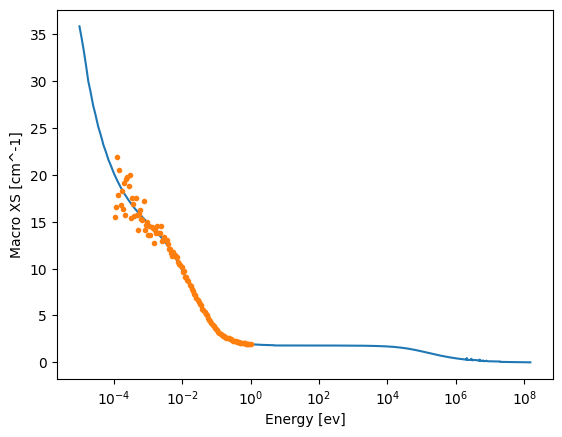

In [9]:
plt.semilogx(E, xs[0])
plt.semilogx(E1,-1/dx*np.log(phi2/phi1), '.')
plt.xlabel('Energy [ev]')
plt.ylabel('Macro XS [cm^-1]')

Well, while doing this exercise I realized the data for polyethylene in the LANL ENDF/B-VIII.0 data libraries is wrong. We can quickly check that by comparing with NCrystal results and experimental data:

In [10]:
m1_nc = openmc.Material.from_ncrystal('Polyethylene_CH2.ncmat')
E_nc, xs_nc = openmc.calculate_cexs(m1_nc, ['total'])

In [11]:
txt = """ 0.001035    223.5       9.6
 0.001161    217.6       6.1
 0.001303    210.5       5.2
 0.001462    213.4       5.6
 0.001641    209.1       4.6
 0.001841    201.4       5.3
 0.002065    195         2.8
 0.002317    191.7       2.2
 0.0026      183.9       2
 0.002917    183.9       2.1
 0.003273    179.7       1.7
 0.003673    173.2       1.7
 0.004121    172.2       1.6
 0.004624    168.6       1
 0.005188    165.1       1.4
 0.005821    161.3       1.1
 0.006531    158.7       0.8
 0.006918    155.7       0.9
 0.007482    153.1       0.8
 0.008072    152.8       1.4
 0.00871     149         0.9
 0.009419    146.4       0.8
 0.01007     145         1
 0.01067     143.1       1
 0.0113      140.3       0.7
 0.01197     139.4       0.8
 0.01268     138.2       1
 0.01343     136.4       0.9
 0.01422     135.2       0.9
 0.01507     133.2       0.8
 0.01596     132.9       0.7
 0.0169      130.5       0.7
 0.01791     128.6       0.7
 0.01897     127.3       0.7
 0.02009     125.8       0.7
 0.02128     124.1       0.5
 0.02254     121.9       0.4
 0.02388     120         0.5
 0.02529     118.6       0.5
 0.02679     117.1       0.5
 0.02838     115.2       0.5
 0.03006     113.2       0.6
 0.03184     111.8       0.5
 0.03373     110.3       0.5
 0.03573     108.5       0.5
 0.03784     105.9       0.4
 0.04009     104.6       0.4
 0.04246     102.5       0.4
 0.04498     100.9       0.4
 0.04764     99.7        0.4
 0.05047     97.1        0.5
 0.05346     95          0.5
 0.05662     93.3        0.4
 0.05998     91.9        0.6
 0.06353     89.9        0.4
 0.0673      87.8        0.4
 0.07129     85.6        0.5
 0.07551     83.4        0.6
 0.07998     81.5        0.6
 0.08472     79.6        0.3
 0.08974     77.6        0.5
 0.09506     75.5        0.4
 0.1007      74          0.6
 0.1067      72.1        0.4
 0.113       69.9        0.5
 0.1197      68          0.5
 0.1268      67.8        0.6
 0.1343      65.8        0.5
 0.1422      64          0.5
 0.1507      63          0.4
 0.1596      62.1        0.7
 0.169       61.1        0.9
 0.1791      60.2        0.6
 0.1897      60.4        0.7
 0.201       58.9        1
 0.2128      59.2        0.6
 0.2254      58.1        0.7
 0.2388      57.8        0.7
 0.2529      56.3        0.6
 0.2679      55.8        1.1
 0.2838      54.8        0.7
 0.3006      53.1        0.6
 0.3273      52          0.7
 0.3673      51.3        0.5
 0.4121      51          0.5
 0.4624      50.7        0.6
 0.5188      50.6        0.8
 0.5821      50.4        0.6
 0.6531      49.3        0.8
 0.7328      49.2        0.5
 0.8222      48.7        0.9
 0.9226      47.4        0.7
 1.096       47.9        0.5
 1.38        46.9        0.5
 1.738       47.1        0.5
 2.188       47.6        0.5
 2.754       46.5        0.7
 3.467       46.7        0.8
 4.227       45.5        1.3
 5.236       46.5        1
 6.653       45.2        0.9
 8.75        46.4        0.8
"""

dawidowski_data = np.fromstring(txt, sep=' ')
dawidowski_data = np.reshape(dawidowski_data, (-1, 3))
E_exp, xs_exp = dawidowski_data[:,0], dawidowski_data[:,1]
N_exp = 0.92*0.6022/14.0

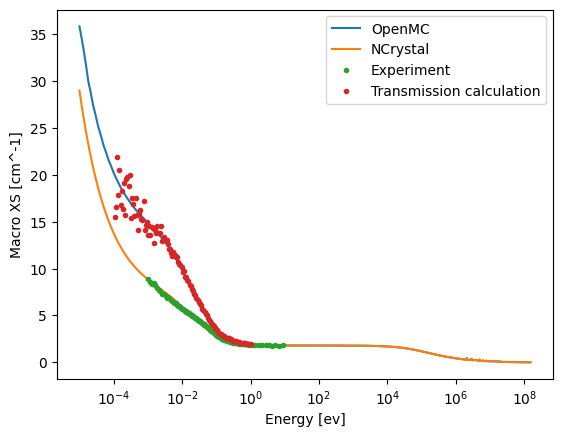

In [12]:
plt.semilogx(E, xs[0], label='OpenMC')
plt.semilogx(E_nc, xs_nc[0], label='NCrystal' )
plt.semilogx(E_exp, N_exp*xs_exp, '.', label='Experiment')
plt.semilogx(E1,-1/dx*np.log(phi2/phi1), '.', label='Transmission calculation')
plt.xlabel('Energy [ev]')
plt.ylabel('Macro XS [cm^-1]')
plt.legend()

But, `openmc.data` allows us to open the data file and update it. In particular, there is a problem with the normalization of the incoherent elastic data. We will open the file, update the value and save it again:

In [13]:
ch2_path = '/home/student/tsl_software/endfb-viii.0-hdf5/neutron/c_H_in_CH2.h5'
data_h5 = openmc.data.ThermalScattering.from_hdf5(ch2_path)

for T in data_h5.temperatures:
    sigma_bound = data_h5.elastic.xs[T].bound_xs
    data_h5.elastic.xs[T].bound_xs = sigma_bound / 2.0
    print(f'Original sigma_bound: {sigma_bound} -> updated to: {(sigma_bound/2.0)}')

ch2_path_bak = ch2_path + '.bak'
os.system(f'mv {ch2_path} {ch2_path_bak}')
data_h5.export_to_hdf5(ch2_path)

Original sigma_bound: 163.627 -> updated to: 81.8135
Original sigma_bound: 163.627 -> updated to: 81.8135
Original sigma_bound: 163.627 -> updated to: 81.8135
Original sigma_bound: 163.627 -> updated to: 81.8135
Original sigma_bound: 163.627 -> updated to: 81.8135
Original sigma_bound: 163.627 -> updated to: 81.8135
Original sigma_bound: 163.627 -> updated to: 81.8135
Original sigma_bound: 163.627 -> updated to: 81.8135
Original sigma_bound: 163.627 -> updated to: 81.8135
Original sigma_bound: 163.627 -> updated to: 81.8135
Original sigma_bound: 163.627 -> updated to: 81.8135


And now we can redo the exercise:

In [14]:
dx = 0.2 # cm
m1 = openmc.Material()
m1.add_elements_from_formula('CH2')
m1.set_density('g/cm3', 0.92)
m1.add_s_alpha_beta('c_H_in_CH2')

model = create_model(m1, slab_thickness=dx)
model.export_to_xml()

In [15]:
!rm summary.h5 statepoint.10.h5
openmc.run(output=True)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [16]:
E1_fix, phi1_fix = get_incident_tally('statepoint.10.h5')
E2_fix, phi2_fix = get_transmitted_tally('statepoint.10.h5')

In [17]:
E, xs = openmc.calculate_cexs(m1, ['total'])

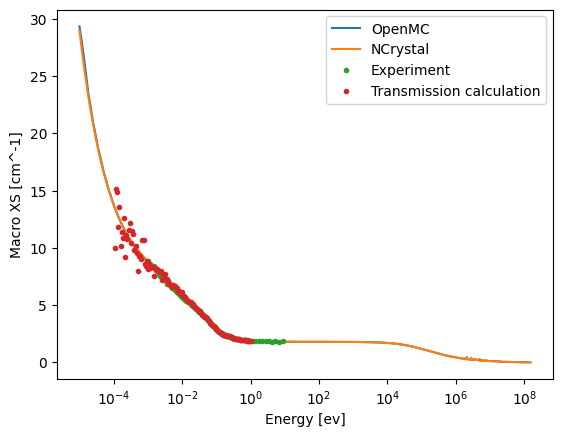

In [18]:
plt.semilogx(E, xs[0], label='OpenMC')
plt.semilogx(E_nc, xs_nc[0], label='NCrystal' )
plt.semilogx(E_exp, N_exp*xs_exp, '.', label='Experiment')
plt.semilogx(E1_fix,-1/dx*np.log(phi2_fix/phi1_fix), '.', label='Transmission calculation')
plt.xlabel('Energy [ev]')
plt.ylabel('Macro XS [cm^-1]')
plt.legend()